# High Dimensional Fixed Effects with Rossman Sales Data

**Intro**

This tutorial demonstrates how you can create models with high dimensional fixed effects using `quantcore.glm`. Thanks to the utilization of `quantcore.matrix`, we can pass categorical variables with a large range of values and the rest is taken care of for us. `quantcore.glm` and `quantcore.matrix` will handle the creation of the one-hot-encoded design matrix and also take advantage of the sparse nature of the matrix to optimize operations.


**Background**

For this tutorial, we will be predicting sales for the European drug store chain. Specifically, we are tasked with predicting daily sales for future dates. Ideally, we want a model that can capture the many factors that influence stores sales -- promotions, competition, school, holidays, seasonality, etc. As a baseline, we will start with a simple model that only uses a few basic predictors. Then, we will fit a model with a large number of fixed effects. For both models, we will use OLS with L2 regularization. 

*Note*: a few parts of this tutorial utilize local helper functions outside this notebook. If you wish to run the notebook on your own, you can find the rest of the code here: <span style="color:red">**TODO**: add link once in master</span>.

## Table of Contents<a class="anchor"></a>
* [1. Data Loading and Feature Engineering](#1.-Data-Loading-and-Feature-Engineering)
* [2. Fit Baseline GLM](#2.-Fit-baseline-GLM)
* [3. GLM with High Dimensional Fixed Effects](#3.-GLM-with-High-Dimensional-Fixed-Effects)
* [4. Plot Results](#4.-Plot-Results)

In [1]:
import os
from pathlib import Path

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dask_ml.impute import SimpleImputer
from dask_ml.preprocessing import Categorizer
from quantcore.glm import GeneralizedLinearRegressor
from sklearn.pipeline import Pipeline

from feature_engineering import apply_all_transformations
from process_data import load_test, load_train, process_data

import sys
sys.path.append("../")
from metrics import root_mean_squared_percentage_error

pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option('display.max_columns', None)
alt.data_transformers.enable("json")  # to allow for large plots

DataTransformerRegistry.enable('json')

## 1. Data loading and feature engineering<a class="anchor"></a>
[back to table of contents](#Table-of-Contents)

We start by loading in the raw data. If you have not yet processed the raw data, it will be done below. (Initial processing consists of some basic cleaning and renaming of columns.

*Note*: if you wish to run this notebook on your own, and have not done so already, please download the data from the [Rossman Kaggle Challenge](https://www.kaggle.com/c/rossmann-store-sales). This tutorial expects that it in a folder names "raw_data" under the same directory as the notebook.

### 1.1 Load

In [2]:
if not all([Path(p).exists() for p in ["raw_data/train.csv", "raw_data/test.csv", "raw_data/store.csv"]]):
    raise Exception("Please download raw data into 'raw_data' folder")

if not all([Path(p).exists() for p in ["processed_data/train.parquet", "processed_data/test.parquet"]]):
    "Processed data not found. Processing data from raw data..."
    process_data()
    "Done"
    
df = load_train().sort_values(["store", "date"])
df = df.iloc[:int(.1*len(df))]
df.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,year,month,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
1016095,1,2,2013-01-01,0,0,False,0,a,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None
1014980,1,3,2013-01-02,5530,668,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None
1013865,1,4,2013-01-03,4327,578,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None
1012750,1,5,2013-01-04,4486,619,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None
1011635,1,6,2013-01-05,4997,635,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None


### 1.2 Feature engineering

As we mention earlier, we want our model to incorporate the many factors that influence store sales. Thus, we create a number of fixed effects to capture this information. These include:

- Fixed effects for a certain number days before a school or state holidays
- Fixed effects for a certain number days after a school or state holidays
- Fixed effects for a certain number days before a promo
- Fixed effects for a certain number days after a promo
- Fixed effects for a certain number days before the store is open or closed
- Fixed effects for a certain number days after the store is open or closed
- Fixed effects for each month for each store
- Fixed effects for each year for each store
- Fixed effects for each day of the week for each store

In addition to fixed effects, we also do several other transformations. These include:

- Taking the log of sales. It is expected that the factors influencing store sales like locality, seasonality, etc. will have a multiplicative effect on sales rather than additive, so going foward, we use log of sales as our outcome variable
- Computing the z score to eliminate outliers (in the next step)

In [3]:
df = apply_all_transformations(df)
df.head()

/Users/mabasta/opt/anaconda3/envs/quantcore.glm/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,year,month,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,age_quantile,competition_open,count,log_sales,open_lag_1,open_lag_2,open_lag_3,open_lead_1,open_lead_2,open_lead_3,promo_lag_1,promo_lag_2,promo_lag_3,promo_lead_1,promo_lead_2,promo_lead_3,school_holiday_lag_1,school_holiday_lag_2,school_holiday_lag_3,school_holiday_lead_1,school_holiday_lead_2,school_holiday_lead_3,state_holiday_lag_1,state_holiday_lag_2,state_holiday_lag_3,state_holiday_lead_1,state_holiday_lead_2,state_holiday_lead_3,store_day_of_week,store_month,store_school_holiday,store_state_holiday,store_year,zscore
1016095,1,2,2013-01-01,0,0,False,0,a,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,-1,1.000,0,-inf,1.0,1.0,1.0,True,True,True,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0,0,0,0,0,0,1_2,1_1,1_1,1_True,1_2013,NaN
1014980,1,3,2013-01-02,5530,668,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,-1,1.000,1,8.618,False,1.0,1.0,True,True,True,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,1.000,a,0,0,0,0,0,1_3,1_1,1_1,1_False,1_2013,NaN
1013865,1,4,2013-01-03,4327,578,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,-1,1.000,2,8.373,True,False,1.0,True,True,False,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0,a,0,0,0,0,1_4,1_1,1_1,1_False,1_2013,NaN
1012750,1,5,2013-01-04,4486,619,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,-1,1.000,3,8.409,True,True,False,True,False,True,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0,0,a,0,0,0,1_5,1_1,1_1,1_False,1_2013,NaN
1011635,1,6,2013-01-05,4997,635,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,-1,1.000,4,8.517,True,True,True,False,True,True,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0,0,0,0,0,0,1_6,1_1,1_1,1_False,1_2013,NaN


### 1.3 Train vs. validation selection

Lastly, we split our data into training and validation sets. Kaggle provides a test set for the Rossman challenge, but it does not directly include outcome data (sales), so we do not use it for our tutorial. Instead, we simulate predicting future sales by taking the last 5 months of our training data as our validation set. 

In [4]:
validation_window = [pd.to_datetime("2015-03-15"), pd.to_datetime("2015-07-31")]
select_train = (df["sales"].gt(0) & df["date"].lt(validation_window[0]) & df["zscore"].abs().lt(5)).to_numpy()

select_val = (
    df["sales"].gt(0)
    & df["date"].ge(validation_window[0])
    & df["date"].lt(validation_window[1])
).to_numpy()


(select_train.sum(), select_val.sum())

(57876, 12502)

## 2. Fit baseline GLM<a class="anchor"></a>
[back to table of contents](#Table-of-Contents)

We start with a simple model that uses only year, month, day of the week, and store as predictors. Even with these variables alone, we should still be able to capture a lot of valuable information. Year can capture overall sales trends, month can capture seasonality, week day can capture the variation in sales across the week, and store can capture locality. We will treat these all as categorical variables. 

*Note*: notice how with the `GeneralizedLinearRegressor()` class, we pass in the categorical variables directly without having to encode them ourselves. This is extremely convenient, especially when we start adding more fixed effects.  However, this does require that we use a Categorizer (we use the dask ml categorizer) for 2 reasons.
1. To ensure that the categories align in fitting and predicting. (Note also that Dask ML's Categorizer doesn't enforce the order of categories if the input column is already categorical.)
2. In order to transform the columns into categorical data types. 

You can reference the [pandas documentation on Categoricals](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to learn more about how these data types work.

In [5]:
baseline_features = ["year", "month", "day_of_week", "store"]
baseline_categorizer = Categorizer(columns=baseline_features)
baseline_glm = GeneralizedLinearRegressor(
    family="normal",
    scale_predictors=True,
    l1_ratio=0.0,
    alphas=1e-1,
)

Fit the model making sure to process the dataframe with the Categorizer first and inspect the coefficients. 

In [6]:
baseline_glm.fit(
    baseline_categorizer.fit_transform(df[select_train][baseline_features]),
    df.loc[select_train, "log_sales"]
)

pd.DataFrame(
    {'coefficient': np.concatenate(([baseline_glm.intercept_], baseline_glm.coef_))},
    index=['intercept'] + baseline_glm.feature_names_
).T

,intercept,year__2013,year__2014,year__2015,month__1,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,day_of_week__1,day_of_week__2,day_of_week__3,day_of_week__4,day_of_week__5,day_of_week__6,day_of_week__7,store__1,store__2,store__3,store__4,store__5,store__6,store__7,store__8,store__9,store__10,store__11,store__12,store__13,store__14,store__15,store__16,store__17,store__18,store__19,store__20,store__21,store__22,store__23,store__24,store__25,store__26,store__27,store__28,store__29,store__30,store__31,store__32,store__33,store__34,store__35,store__36,store__37,store__38,store__39,store__40,store__41,store__42,store__43,store__44,store__45,store__46,store__47,store__48,store__49,store__50,store__51,store__52,store__53,store__54,store__55,store__56,store__57,store__58,store__59,store__60,store__61,store__62,store__63,store__64,store__65,store__66,store__67,store__68,store__69,store__70,store__71,store__72,store__73,store__74,store__75,store__76,store__77,store__78,store__79,store__80,store__81,store__82,store__83,store__84,store__85,store__86,store__87,store__88,store__89,store__90,store__91,store__92,store__93,store__94,store__95,store__96,store__97,store__98,store__99,store__100,store__101,store__102,store__103,store__104,store__105,store__106,store__107,store__108,store__109,store__110,store__111,store__112
coefficient,8.741,-0.011,0.007,0.005,-0.016,-0.021,-0.020,0.019,0.009,-0.005,-0.002,-0.021,-0.032,-0.026,0.026,0.104,0.091,0.010,-0.009,-0.007,0.025,-0.110,0.273,-0.153,-0.143,0.023,0.204,-0.181,-0.085,0.158,-0.101,0.012,-0.068,0.114,0.079,-0.133,-0.084,0.018,0.090,-0.036,0.008,-0.003,0.094,-0.094,-0.178,-0.086,0.182,0.265,0.009,0.186,-0.114,0.061,-0.102,-0.042,-0.240,0.132,0.113,0.194,0.193,0.047,-0.049,-0.165,-0.128,-0.079,0.232,0.021,-0.083,-0.098,-0.096,0.048,-0.250,0.065,-0.218,0.020,0.081,-0.106,0.099,-0.191,0.052,0.243,-0.011,-0.100,0.099,-0.148,-0.005,0.037,0.245,-0.129,-0.023,0.090,0.085,0.192,0.010,0.169,-0.211,-0.180,-0.017,-0.027,0.175,0.081,-0.284,-0.087,0.082,0.048,0.158,-0.256,0.353,0.029,-0.159,-0.058,-0.072,-0.035,0.134,-0.058,-0.048,-0.056,0.045,0.083,-0.152,0.011,-0.115,-0.109,0.115,0.078,0.034,-0.168,0.236,-0.179,0.143,0.071,0.278,0.005,-0.176,0.024,-0.023


Note that below, we predict sales for when the stores are open vs. closed separately (as one would expect, sales for days when the stores are closed are 0).

In [7]:
df.loc[lambda x: x["open"], "predicted_log_sales_baseline"] = baseline_glm.predict(
    baseline_categorizer.fit_transform(df.loc[lambda x: x["open"]][baseline_features])
)

df["predicted_log_sales_baseline"] = df["predicted_log_sales_baseline"].fillna(0)
df["predicted_sales_baseline"] = np.exp(df["predicted_log_sales_baseline"])

We use root mean squared percentage error (RMSPE) as our performance metric. (Useful for thinking about error relative to total sales of each store).  

In [8]:
train_err = root_mean_squared_percentage_error(
    df.loc[select_train, "sales"], df.loc[select_train, "predicted_sales_baseline"]
)
val_err = root_mean_squared_percentage_error(
    df.loc[select_val, "sales"], df.loc[select_val, "predicted_sales_baseline"]
)
print(f'Training Error: {round(train_err, 2)}%')
print(f'Validation Error: {round(val_err, 2)}%')

Training Error: 29.52%
Validation Error: 31.54%


The results aren't bad for a start, but we can do better :) 

## 3. GLM with high dimensional fixed effects<a class="anchor"></a>
[back to table of contents](#Table-of-Contents)

Now, we repeat a similar process to above, but this time, we take advantage of the full range of categoricals we created in our data transformation step. Since we will create a very large number of fixed effects, we may run into cases where our validation data has categorical values not seen in our training data. In these cases, the dask_ml Categorizer will output null values when transforming the validation columns to the categoricals that were created on the training set. To fix this, we add the dask_ml [SimpleImputer](https://ml.dask.org/modules/generated/dask_ml.impute.SimpleImputer.html) to our pipeline. 

In [9]:
highdim_features = [
    "age_quantile",
    "competition_open",
    "open_lag_1",
    "open_lag_2",
    "open_lag_3",
    "open_lead_1",
    "open_lead_2",
    "open_lead_3",
    "promo_lag_1",
    "promo_lag_2",
    "promo_lag_3",
    "promo_lead_1",
    "promo_lead_2",
    "promo_lead_3",
    "promo",
    "school_holiday_lag_1",
    "school_holiday_lag_2",
    "school_holiday_lag_3",
    "school_holiday_lead_1",
    "school_holiday_lead_2",
    "school_holiday_lead_3",
    "school_holiday",
    "state_holiday_lag_1",
    "state_holiday_lag_2",
    "state_holiday_lag_3",
    "state_holiday_lead_1",
    "state_holiday_lead_2",
    "state_holiday_lead_3",
    "state_holiday",
    "store_day_of_week",
    "store_month",
    "store_school_holiday",
    "store_state_holiday",
    "store_year",
]
highdim_categorizer = Pipeline([
    ("categorize", Categorizer(columns=highdim_features)),
    ("impute", SimpleImputer(strategy="most_frequent"))
])
highdim_glm = GeneralizedLinearRegressor(
    family="normal",
    scale_predictors=True,
    l1_ratio=0.0, # only ridge
    alpha=1e-1,
)

For reference, we output the total number of predictors after fitting the model. We can see that the number getting a bit larger, so we don't print out the coefficients this time.

In [10]:
highdim_glm.fit(
    highdim_categorizer.fit_transform(df[select_train][highdim_features]),
    df.loc[select_train, "log_sales"]
)

print(f"Number of predictors: {len(highdim_glm.feature_names_)}")

Number of predictors: 2771


In [11]:
df.loc[lambda x: x["open"], "predicted_log_sales_highdim"] = highdim_glm.predict(
    highdim_categorizer.transform(df.loc[lambda x: x["open"]][highdim_features]),
)

df["predicted_log_sales_highdim"] = df["predicted_log_sales_highdim"].fillna(0)
df["predicted_sales_highdim"] = np.exp(df["predicted_log_sales_highdim"])


train_err = root_mean_squared_percentage_error(
    df.loc[select_train, "sales"], df.loc[select_train, "predicted_sales_highdim"]
)
val_err = root_mean_squared_percentage_error(
    df.loc[select_val, "sales"], df.loc[select_val, "predicted_sales_highdim"]
)
print(f'Training Error: {round(train_err, 2)}%')
print(f'Validation Error: {round(val_err, 2)}%')

Training Error: 12.82%
Validation Error: 13.69%


From just the RMSPE, we can see a clear improvement from our baseline model.

## 4. Plot results<a class="anchor"></a>
[back to table of contents](#Table-of-Contents)

Finally, to get a better look at our results, we make some plots.

In [12]:
sales_cols = ["sales", "predicted_sales_highdim", "predicted_sales_baseline"]

First, we plot true sales and the sales predictions from each model aggregated over month

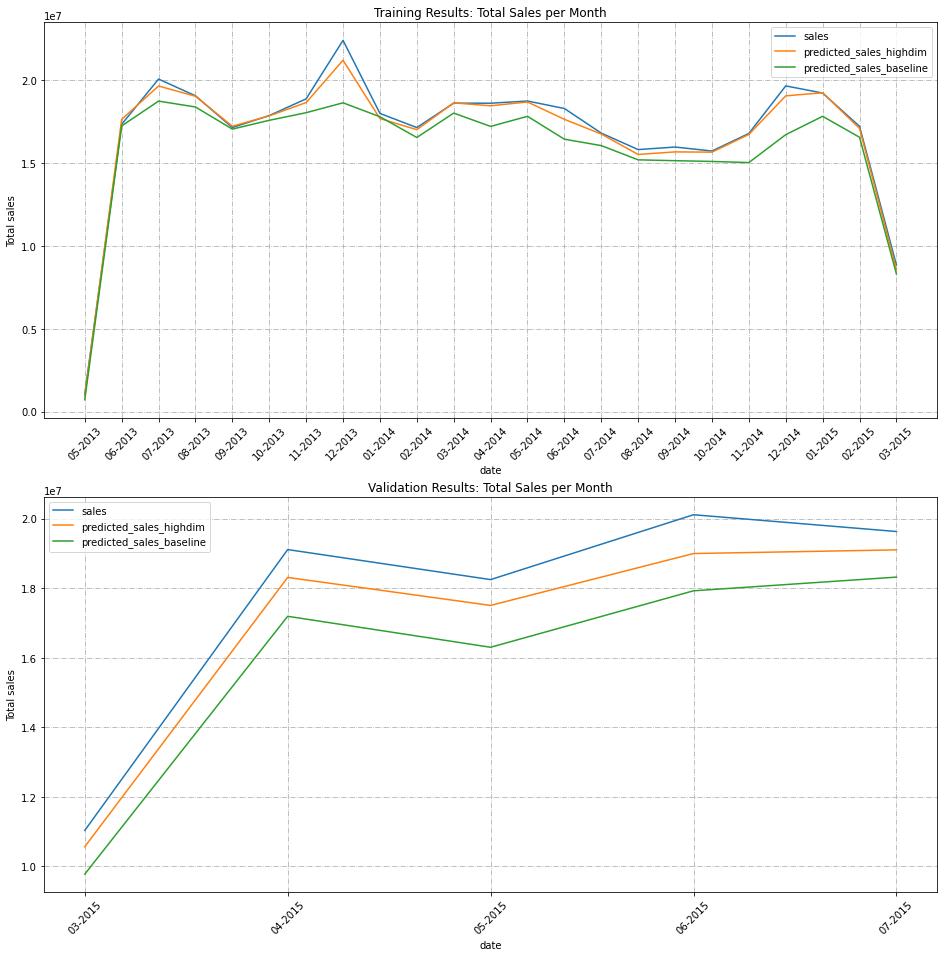

In [13]:
_, axs = plt.subplots(2, 1, figsize=(16, 16))

for i, select in enumerate([select_train, select_val]):
    ax = axs[i]
    df_plot_date = df[select].groupby(
        ["year", "month"]
    ).agg("sum")[sales_cols].reset_index()

    year_month_date = df_plot_date['month'].map(str)+ '-' + df_plot_date['year'].map(str)
    df_plot_date['year_month'] = pd.to_datetime(year_month_date, format='%m-%Y').dt.strftime('%m-%Y')
    df_plot_date.drop(columns= ["year", "month"], inplace=True)

    df_plot_date.plot(x="year_month", ax=ax)
    ax.set_xticks(range(len(df_plot_date)))
    ax.set_xticklabels(df_plot_date.year_month, rotation=45)
    ax.set_xlabel("date")
    ax.set_ylabel("Total sales")
    ax.grid(True, linestyle='-.')

axs[0].set_title("Training Results: Total Sales per Month")
axs[1].set_title("Validation Results: Total Sales per Month")
plt.show()

We can also look at aggregate sales for a subset of stores. We select the first 20 stores and plot in order of increasing sales. 

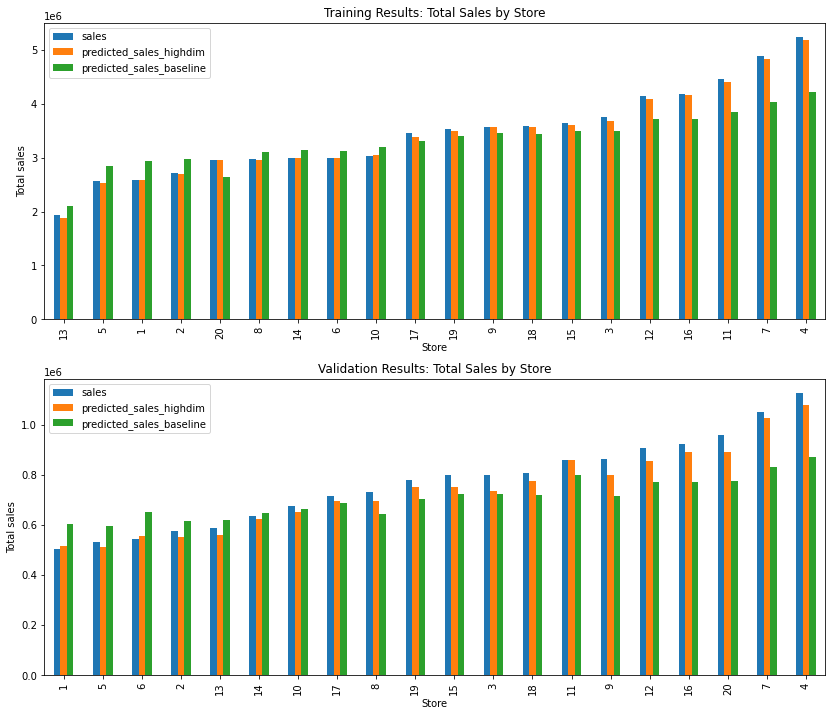

In [14]:
_, axs = plt.subplots(2, 1, figsize=(14, 12))
for i, select in enumerate([select_train, select_val]):
    ax = axs[i]
    df_plot_store = df[select].groupby(
        ["store"]
    ).agg("sum")[sales_cols].reset_index()[:20].sort_values(by="sales")

    df_plot_store.plot.bar(x="store", ax=ax)
    ax.set_xlabel("Store")
    ax.set_ylabel("Total sales")

axs[0].set_title("Training Results: Total Sales by Store")
axs[1].set_title("Validation Results: Total Sales by Store")
plt.show()

We can see that the high dimensional model is much better at capturing the variation between months and individual stores!